#training an OCR reader with Keras


In [ ]:
#training an OCR reader with tensorflow
!pip install tensorflow
!pip install lxml pandas numpy opencv-python

In [6]:
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K

train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/content/drive/MyDrive/ANPR/OCRforNumPlates'
train_generator = train_datagen.flow_from_directory(
        path+'/train',
        target_size=(28,28),  #all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',
        target_size=(28,28),  #all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [ ]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")

def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=[custom_f1score])

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

path = '/content/drive/MyDrive/ANPR/OCRforNumPlates'
train_dataset = datasets.ImageFolder(root=path+'/train', transform=transform)
val_dataset = datasets.ImageFolder(root=path+'/val', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [3]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")

def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001))
model.summary()

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') >=0.99):
              self.model.stop_training = True

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      epochs = 300, verbose=1, callbacks=callbacks)
store_keras_model(model, 'OCR_reader')

In [ ]:
!pip install beautifulsoup4

# Using YOLO for number plate recognition

In [ ]:


def normalized_coordinates(filename, width, height, xmin, ymin, xmax, ymax):
    xmin, xmax = xmin / width, xmax / width
    ymin, ymax = ymin / height, ymax/ height

    width = xmax-xmin
    height = ymax-ymin
    x_center = xmin + (width / 2)
    y_center = ymin + (height / 2)

    return x_center, y_center, width, height

def write_label(filename, x_center, y_center, width, height):

    with open(filename, mode='w') as outf:
        outf.write(f"{0} {x_center} {y_center} {width} {height}\n")

def parse_xml_tags(data):
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d

def build_data(dir_folder, ann_file_list, img_dir):
    images_folder = f"{dir_folder}/images"
    labels_folder = f"{dir_folder}/labels"

    os.makedirs(images_folder, exist_ok = True)
    os.makedirs(labels_folder, exist_ok = True)


    for ann_file in ann_file_list:
        with open(ann_file, 'r') as f:
            label = parse_xml_tags(f.read())

        img_file_name = label['filename']
        x_center, y_center, width, height = normalized_coordinates(**label)

        # save at 'labels' folder
        write_label(f"{labels_folder}/{img_file_name.split('.')[0]}.txt", x_center, y_center, width, height)

         # Move image to 'images' folder
        shutil.copy(f"{img_dir}/{img_file_name}", f"{images_folder}/{img_file_name}")

In [ ]:
import glob
import os
from bs4 import BeautifulSoup
import shutil
dir_folder = "/content/drive/MyDrive/ANPR"
#making sure that images are in right format for yolo
ann_list = glob.glob('/content/drive/MyDrive/ANPR/numberplateDetection/images/*.xml')
build_data(dir_folder, ann_list, "/content/drive/MyDrive/ANPR/numberplateDetection/images")

ann_list = glob.glob('/content/drive/MyDrive/ANPR/archive/annotations/*')
build_data(dir_folder, ann_list, "/content/drive/MyDrive/ANPR/archive/images")



In [ ]:
import yaml

data = {
    "path": dir_folder,
    "train": "images",
    "val": "",
    "names": {0: "car_lisence_plate"}
    }

with open('/content/drive/MyDrive/ANPR/dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)



In [ ]:
assert len(os.listdir("/content/drive/MyDrive/ANPR/labels")) == len(os.listdir("/content/drive/MyDrive/ANPR/images"))

In [ ]:
!pwd
%cd /content/drive/MyDrive/ANPR
!pwd

/content
/content/drive/MyDrive/ANPR
/content/drive/MyDrive/ANPR


# Installing YOLO

In [ ]:
#git clone https://github.com/ultralytics/yolov5  # clone
%cd /content/drive/MyDrive/ANPR/yolov5
!pip install -r requirements.txt

# Training YOLO with varying batch sizes and optimisers

In [ ]:
!python train.py --img 640 --batch 16 --epochs 16 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram

In [ ]:
#Greg 16 epochs 16 batch
!python train.py --img 640 --batch 16 --epochs 16 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --device 0 --project /content/drive/MyDrive/ANPR

In [ ]:
#Greg 16 epochs 32 batch
!python train.py --img 640 --batch 32 --epochs 16 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --device 0 --project /content/drive/MyDrive/ANPR

In [ ]:
#Using Adam to train (Greg)
!python train.py --optimizer Adam --img 640 --batch 32 --epochs 16 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --project /content/drive/MyDrive/ANPR

In [ ]:
#Using AdamW to train (Greg)
!python train.py --optimizer AdamW --img 640 --batch 32 --epochs 16 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --project /content/drive/MyDrive/ANPR

In [ ]:
#Using SGD to train (Greg)
!python train.py --optimizer SGD --img 640 --batch 32 --epochs 16 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --project /content/drive/MyDrive/ANPR

In [ ]:
#Using Adam to train (Greg) 32 epochs
!python train.py --optimizer Adam --img 640 --batch 32 --epochs 32 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --project /content/drive/MyDrive/ANPR

In [ ]:
#Using AdamW to train (Greg) 32 epochs
!python train.py --optimizer AdamW --img 640 --batch 32 --epochs 32 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --project /content/drive/MyDrive/ANPR

In [ ]:
#Using SGD to train (Greg) 32 epochs
!python train.py --optimizer SGD --img 640 --batch 32 --epochs 32 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --project /content/drive/MyDrive/ANPR

In [ ]:
#Using AdamW to train (Greg) 64 epochs
!python train.py --optimizer AdamW --img 640 --batch 32 --epochs 62 --data /content/drive/MyDrive/ANPR/dataset.yaml --weights yolov5s.pt --cache ram --multi-scale --project /content/drive/MyDrive/ANPR

In [ ]:
!pip install torch
!pip install easyocr

In [ ]:
#10 epochs
import torch

yolo_10 = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ANPR/yolov5/runs/train/exp/weights/best.pt')

In [ ]:
#16 epochs with Adam
import torch

yolo_16Adam = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ANPR/Adam_16epoch_batch32/weights/best.pt')
yolo_16AdamW = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ANPR/AdamW_16epoch_batch32/weights/best.pt')
yolo_16SGD = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ANPR/SGD_16epoch_batch32/weights/best.pt')
yolo_32AdamW = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ANPR/AdamW_32epoch_batch32/weights/best.pt')
yolo_32Adam = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ANPR/Adam_32epoch_batch32/weights/best.pt')
yolo_32SGD = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ANPR/SGD_32epoch_batch32/weights/best.pt')

# Loading YOLO 32 epoch with ADAM

In [ ]:
yolo_32Adam = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ANPR/Adam_32epoch_batch32/weights/best.pt')

In [36]:
img = '/content/drive/MyDrive/ANPR/CAR6.jpg'

# Inference

results = yolo_32Adam(img)

cordinates = results.xyxy[0][:, :-1]
results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,106.079758,77.088264,168.771332,92.865631,0.787031,0,car_lisence_plate


In [35]:
from google.colab.patches import cv2_imshow

# Using YOLO to draw a bounding box around the number plate and then extracting the number plate and segmenting for character recognition

[]


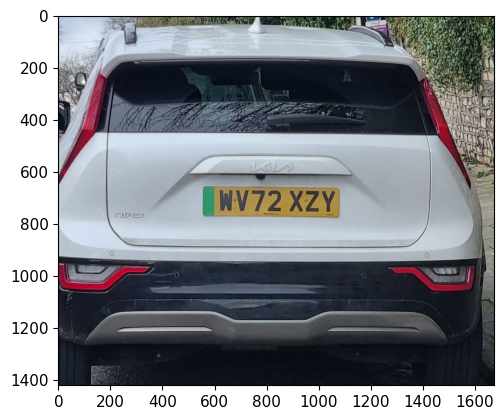

In [30]:
#This file saves the plates of the cars
import matplotlib.pyplot as plt

%matplotlib inline

#digits that the OCR model struggles with: 0,W,S,6,9,L,P,8,V
img = '/content/drive/MyDrive/ANPR/TAXI.jpg' #Not so clear number plate but still readable
#img = '/content/drive/MyDrive/ANPR/CAR4.jpg' #Not so clear number plate but still readable
#img = '/content/drive/MyDrive/ANPR/CAR5.jpg' #struggles with 0
img = '/content/drive/MyDrive/ANPR/CAR6.jpg'
#img = '/content/drive/MyDrive/ANPR/CAR10.jpg' #struggles with 0
#img = '/content/drive/MyDrive/ANPR/CAR11.jpg' #struggles with 9 and 0
#img = '/content/drive/MyDrive/ANPR/CAR14.jpg'
#img = '/content/drive/MyDrive/ANPR/CAR15.jpg' #struggles with 0,8
img = '/content/drive/MyDrive/ANPR/CAR17.jpg'


results = yolo_32Adam(img)

cordinates = results.xyxy[0][:, :-1]
results.pandas().xyxy[0]

import cv2
import os

def preprocess_and_save_plate(plate, save_path, target_size=(200, 50)):
    plate_resized = cv2.resize(plate, target_size)
    plate_rgb = cv2.cvtColor(plate_resized, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path, plate_rgb)

def read_plate_number(results, frame, save_dir):
    n = len(results)
    plate_numbers = []
    plot_img = frame.copy()

    for i, row in enumerate(results):
        if row[4] >= 0.5:
            xmin, ymin, xmax, ymax = map(int, row[:4])
            plate = frame[ymin:ymax, xmin:xmax]

            cropped_plate_path = os.path.join(save_dir, f"plate_{i}.jpg")
            preprocess_and_save_plate(plate, cropped_plate_path)

    with open(os.path.join(save_dir, 'numberplates.txt'), 'w') as f:
        for plate_number in plate_numbers:
            f.write(plate_number + '\n')

    print(plate_numbers)
    return plot_img



frame = cv2.imread(img)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
save_dir = '/content/drive/MyDrive/ANPR/Plates'

result_img = read_plate_number(cordinates, frame, save_dir)

plt.imshow(result_img)
plt.show()


[]


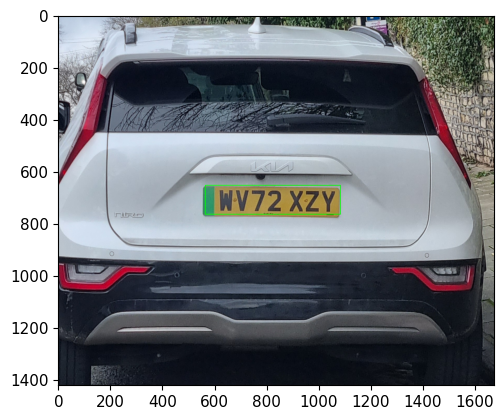

In [31]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

def preprocess_and_save_plate(plate, save_path, target_size=(200, 50)):
    plate_resized = cv2.resize(plate, target_size)
    plate_rgb = cv2.cvtColor(plate_resized, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path, plate_rgb)

def read_plate_number(results, frame, save_dir):
    n = len(results)
    plate_numbers = []
    plot_img = frame.copy()

    for i, row in enumerate(results):
        if row[4] >= 0.5:
            xmin, ymin, xmax, ymax = map(int, row[:4])
            plate = frame[ymin:ymax, xmin:xmax]
            cropped_plate_path = os.path.join(save_dir, f"plate_{i}.jpg")
            preprocess_and_save_plate(plate, cropped_plate_path)
            cv2.rectangle(plot_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    with open(os.path.join(save_dir, 'numberplates.txt'), 'w') as f:
        for plate_number in plate_numbers:
            f.write(plate_number + '\n')

    print(plate_numbers)
    return plot_img

img = '/content/drive/MyDrive/ANPR/CAR17.jpg'
frame = cv2.imread(img)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
save_dir = '/content/drive/MyDrive/ANPR/Plates'

result_img = read_plate_number(cordinates, frame, save_dir)

plt.imshow(result_img)
plt.show()


Segmentation successful with 7 segments found.


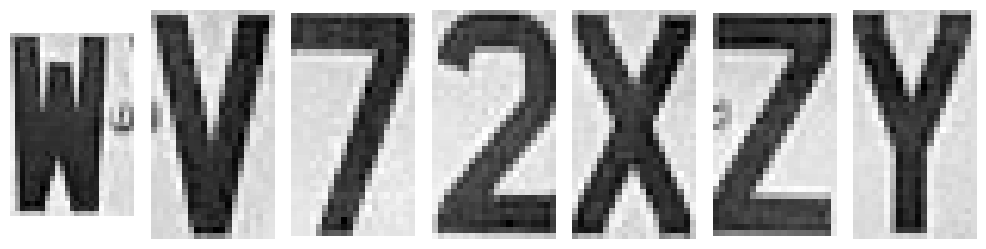

In [32]:
#This code block sepperates the plate characters and turns them gray
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

def segment_characters_advanced(image_path, min_segments=7, max_attempts=10000, save_path="segments"):
    gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if gray_img is None:
        print("Error loading the image. Please check the file path and try again.")
        return [], None

    attempts = 10 #This loops until there are individual segments for each character
    while attempts < max_attempts:
        kernel_size = (attempts % 5) * 2 + 3
        blurred_img = cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 0)

        blockSize = (attempts % 3) * 2 + 11
        C = (attempts // 3) - 2
        binary_img = cv2.adaptiveThreshold(
            blurred_img,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            blockSize,
            C
        )
        kernel = np.ones((3, 3), np.uint8)
        morphed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(morphed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #This finds contours

        char_imgs = []
        char_contours = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)

            if 0.2 < aspect_ratio < 0.7 and 15 < area < 1500 and 20 < h < 50 and 5 < w < 50:
                char_contours.append((x, y, w, h, contour))

        char_contours = sorted(char_contours, key=lambda b: b[0])

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for i, (x, y, w, h, contour) in enumerate(char_contours):
            char_img = gray_img[y:y+h, x:x+w]
            char_imgs.append(char_img)

            cv2.imwrite(os.path.join(save_path, f"segment_{i}.png"), char_img)

        if len(char_imgs) >= min_segments:
            return char_imgs, morphed_img

        attempts += 1

    return [], None

image_path = '/content/drive/MyDrive/ANPR/Plates/plate_0.jpg'

char_imgs, morphed_img = segment_characters_advanced(image_path)

if char_imgs:
    print(f"Segmentation successful with {len(char_imgs)} segments found.")
    plt.figure(figsize=(10, 4))
    for i, char_img in enumerate(char_imgs):
        plt.subplot(1, len(char_imgs), i+1)
        plt.imshow(char_img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Failed to segment characters after max attempts.")
    if morphed_img is not None:
        plt.imshow(morphed_img, cmap='gray')
        plt.title('Best Effort Morphed Image')
        plt.axis('off')
        plt.show()


Segmentation successful with 7 segments found.


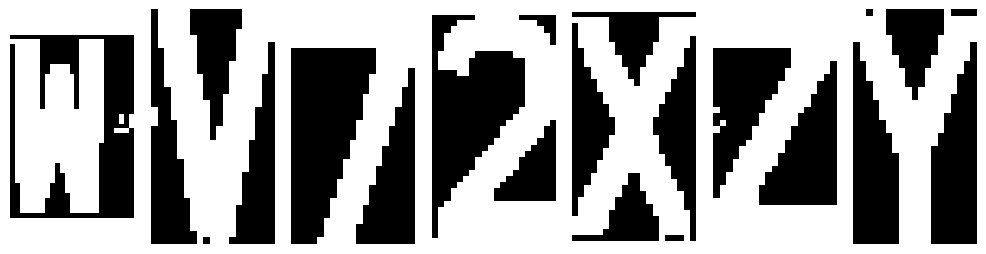

In [37]:
#This one seperates characters and turns them black and white
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

def segment_characters_advanced(image_path, min_segments=6, max_attempts=10000, save_path="segments"):
    gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if gray_img is None:
        print("Error loading the image. Please check the file path and try again.")
        return [], None

    attempts = 20
    while attempts < max_attempts:
        kernel_size = (attempts % 5) * 2 + 3
        blurred_img = cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 0)

        blockSize = (attempts % 3) * 2 + 11
        C = (attempts // 3) - 2

        binary_img = cv2.adaptiveThreshold(
            blurred_img,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            blockSize,
            C
        )

        kernel = np.ones((3, 3), np.uint8)
        morphed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(morphed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        char_imgs = []
        char_contours = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(contour)

            if 0.2 < aspect_ratio < 0.7 and 15 < area < 1500 and 20 < h < 50 and 5 < w < 50:
                char_contours.append((x, y, w, h, contour))

        char_contours = sorted(char_contours, key=lambda b: b[0])

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for i, (x, y, w, h, contour) in enumerate(char_contours):
            char_img = gray_img[y:y+h, x:x+w]

            _, binary_char_img = cv2.threshold(char_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

            char_imgs.append(binary_char_img)
            cv2.imwrite(os.path.join(save_path, f"segment_{i}.png"), binary_char_img)

        if len(char_imgs) >= min_segments:
            return char_imgs, morphed_img

        attempts += 1

    return [], None

image_path = '/content/drive/MyDrive/ANPR/Plates/plate_0.jpg'

char_imgs, morphed_img = segment_characters_advanced(image_path)

if char_imgs:
    print(f"Segmentation successful with {len(char_imgs)} segments found.")
    plt.figure(figsize=(10, 4))
    for i, char_img in enumerate(char_imgs):
        plt.subplot(1, len(char_imgs), i+1)
        plt.imshow(char_img, cmap='binary')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Failed to segment characters after max attempts.")
    if morphed_img is not None:
        plt.imshow(morphed_img, cmap='gray')
        plt.title('Best Effort Morphed Image')
        plt.axis('off')
        plt.show()


1/1 [==============================] - 0s 65ms/step


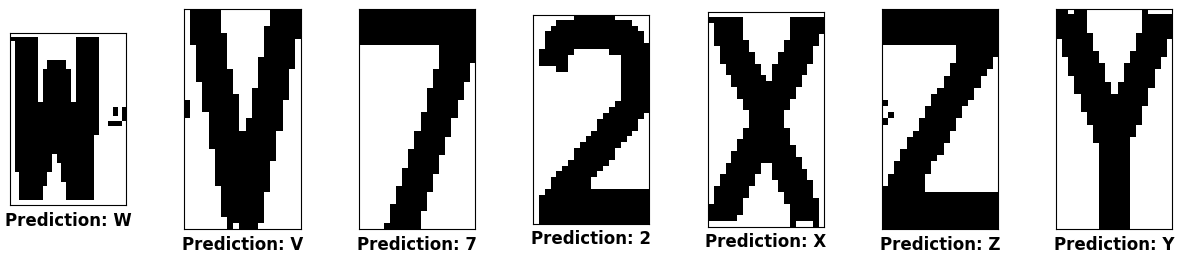

In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

dic = {}
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for i, c in enumerate(characters):
    dic[i] = c

pre_trained_model = load_keras_model('/content/drive/MyDrive/ANPR/OCR_READ_300epoch')
model = pre_trained_model

segment_folder = '/segments'

segment_files = os.listdir(segment_folder)
segment_files.sort()

num_images = len(segment_files)
num_cols = num_images
num_rows = 1

plt.figure(figsize=(15, 3))

for i, filename in enumerate(segment_files):
    image_path = os.path.join(segment_folder, filename)
    image = cv2.imread(image_path)

    if image is not None:
        resized_image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)

        inverted_image = cv2.bitwise_not(resized_image)

        input_image = np.expand_dims(inverted_image, axis=0)

        prediction = model.predict(input_image)
        predicted_class = np.argmax(prediction)
        character = dic[predicted_class]

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.xlabel(f"Prediction: {character}", fontsize=12, fontweight='bold')
        plt.xticks([])
        plt.yticks([])

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()
